# ALERT Doctoral School 2023

## Hands-on physics-informed neural networks


Authors: Filippo Masi, Ioannis Stefanou


### Objectives
- Re-discover ballistics using neural networks (NN) and physics-informed neural networks (PINN).

#### Disclaimer

This hands-on notebook is devoted to **Physics-Informed Neural Networks** (PINN) and it covers chapter 9.<br>
In the following, the code cells introduced by a tag **[TODO]** are meant to be completed by you!

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
torch.manual_seed(123)
np.random.seed(123)
colorb=(0.2,0.4,0.7)

### 1. Introduction: the physics of the motion of a projectile

***Problem:*** The (one-dimensional) motion of the projectile is governed by the ordinary differential equation

$
    \ddot{u}(t) + g = 0,
$

where $u$, $\dot{u}$, and $\ddot{u}$ are the trajectory, velocity, and acceleration of the projectile; $t$ is the time; and $g$ is the gravitational acceleration.

Given the initial conditions $u(0) = u_0$ and $\dot{u}(0) = \dot{u}_0$, the general solution reads

$    u(t) = u_0+\dot{u}_0 t-\tfrac{1}{2} g t^2.
$

***Data generation:*** We generate $N=50$ snapshots of the projectile trajectory by solving the above initial value problem (given by the function `projectile_motion(t,u)` below), using `solve_ivp` from `scipy` library, considering the following initial conditions:

$
u_0 = 0.0 \text{ m}, \quad \dot{u}_0 = 5.0 \text{ m/s}.
$

In [2]:
from scipy.integrate import solve_ivp
def projectile_motion(t, u):
    # Equations of motion
    dudt = u[1]  # velocity
    dduddt = -g   # acceleration
    return [dudt, dduddt]

# Initial conditions
initial_position = 0.0  # meters
initial_velocity = 5.0  # meters per second
g = 9.81  # acceleration due to gravity
# Time span
t_start = 0.0  # seconds
t_end = 1.0  # seconds
n_snapshots = 50

# Time points at which to evaluate the solution
t = np.linspace(t_start, t_end, n_snapshots)
# Solve the differential equation
sol = solve_ivp(projectile_motion, [t_start, t_end], [initial_position, initial_velocity], t_eval=t)
# Extract the trajectory from the solution and convert values to single precision
u = np.float32(sol.y[0]).copy()
t = np.float32(t).copy()

***Synthetic noise***: Let us also add a Gaussian measurement noise on the data representing the trajectory, $u(t)$.


**Disclaimer**<br>
For training, we will only use the first 25 snapshots, $t\in \left[0,0.5\right]$ s.<br>
Then, we will evaluate the model's predictions for the second 25 snapshots, i.e., $t\in \left[0.5,1\right]$ s (extrapolation).

In [3]:
t_i = t[:n_snapshots//2].copy() # trajectory snapshots for training
u_i = u[:n_snapshots//2].copy() # time snapshots for training
u_i += 0.2 * np.multiply(np.random.normal(0,1,n_snapshots//2), u_i) # add noise
u_i[0] = 0.0 # no noise at initial condition
t_i = torch.tensor(t_i)[:,None] # expand dim
u_i = torch.tensor(u_i)[:,None] # expand dim

***Visualization:*** Below we plot the analytical solution for $t\in \left[0,1\right]$ s and the noisy measurement data in the range $t\in \left[0,0.5\right]$ s that will be used for training.

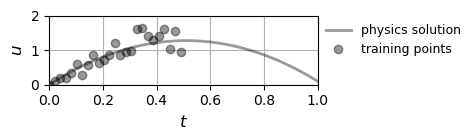

In [4]:
fig = plt.figure(dpi=100, figsize=(5, 1.5), tight_layout=True)
ax = fig.subplots(1)
ax.plot(t, u, color="black", linewidth=2, alpha=0.4, label="physics solution")
ax.plot(t_i, u_i, marker='o', color='black', markersize=6,linewidth=0,alpha=0.4, markeredgecolor='black',label='training points')        
l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="9")
ax.grid()
ax.set_ylabel('$u$',fontsize="12")
ax.set_xlabel('$t$',fontsize="12")
fig.patch.set_facecolor('white')
ax.set_xlim(0.,1)
ax.set_ylim(-0., 2)
plt.show()

### 2.  Standard neural network (physics-agnostic)

We continue by defining a neural network (in `PyTorch`). We will train it in the traditional way (and following the general setting provided by PINN, in the next Section).

The code below (class `NeuralNet`) serves to construct a general neural network architecture with inputs of dimension `i_dim`, outputs of dimension `o_dim`, hidden layers with `h_dim` nodes, and ReLU/Tanh activations:

In [5]:
class NeuralNet(torch.nn.Module):
    
    '''Fully connected feed-forward neural network'''
    def __init__(self,params,dtype=torch.float32):
        super(NeuralNet, self).__init__()
        self.dtype = dtype
        self.NN = self.constructor(params) # neural net
        self.gamma = torch.nn.Parameter(torch.tensor(1.)) # gamma in PINN (trainable parameter)
        
    def constructor(self, params):
        '''Construct neural net'''
        i_dim,o_dim,h_dim,act = params
        dim = i_dim
        layers = torch.nn.Sequential()
        for hdim in h_dim:
            layers.append(torch.nn.Linear(dim, hdim, dtype=self.dtype))
            if act == 'tanh':
                layers.append(torch.nn.Tanh())
            elif act == 'relu':
                layers.append(torch.nn.ReLU())                
            dim = hdim
        layers.append(torch.nn.Linear(dim, o_dim, dtype=self.dtype))
        return layers
    
    def init_weights(self,m):
        if isinstance(m, torch.nn.Linear):
            m.weight.data.normal_(0.0, 1.0)
            m.bias.data.fill_(0.0)
            
    def forward(self, x):
        '''Forward pass'''
        return self.NN(x)

***Task:*** We want to learn the neural operator ${u}_{\boldsymbol{\theta}}$, parametrized by $\boldsymbol{\theta}$ (weights and biases of all layers), such that

$
\boldsymbol{\theta} = \text{argmin} \,\mathcal{L}_u, \quad \mathcal{L}_u = \frac{1}{N} \sum_{i=0}^N \Big({u}_{\boldsymbol{\theta}}(t^i) - u^i \Big)^2, \quad u^i = u(t^i).
$

In other words, we want to learn the relationship that exists between the trajectory $u$ and the time $t$ via a standard neural network.

We generate the architecture is composed of two hidden layers, with 12 nodes each and nonlinear activations (either ReLU or Tanh):

In [6]:
dtype = torch.float32 # single precision
activation = 'tanh' # activation: 'relu' or 'tanh'
NN_params = [1,1,[12,12],activation] # list: i_dim, o_dim, [h_dim, h_dim], 'activation'
model = NeuralNet(NN_params,dtype)
model.apply(model.init_weights)

print(model)

NeuralNet(
  (NN): Sequential(
    (0): Linear(in_features=1, out_features=12, bias=True)
    (1): Tanh()
    (2): Linear(in_features=12, out_features=12, bias=True)
    (3): Tanh()
    (4): Linear(in_features=12, out_features=1, bias=True)
  )
)


We train the network by means of a very simple batch gradient descent with Adam optimizer up to 40'000 epochs.<br>
**Note:** The code hereinafter additionally computes and stores the $\ell_1$- and $\ell_2$-norms of the parameters $\boldsymbol{\theta}$ of the model (see later).

epoch:    0 - train_loss:  0.900888


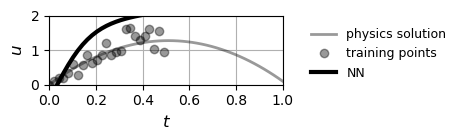

epoch: 4000 - train_loss:  0.014097


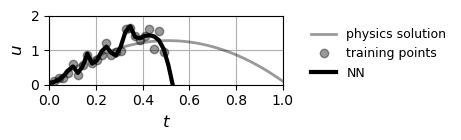

epoch: 8000 - train_loss:  0.000738


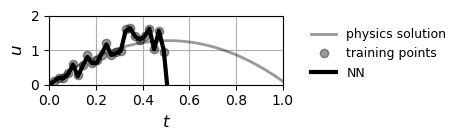

epoch:12000 - train_loss:  0.000246


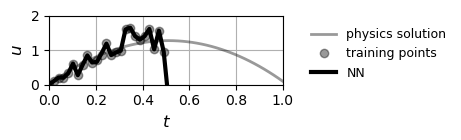

epoch:16000 - train_loss:  0.000294


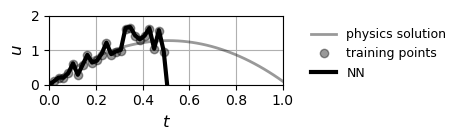

epoch:20000 - train_loss:  0.000101


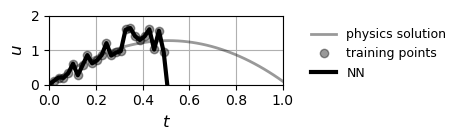

epoch:24000 - train_loss:  0.000017


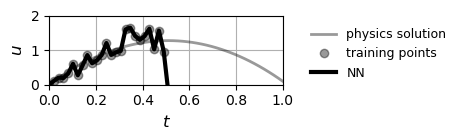

epoch:28000 - train_loss:  0.000089


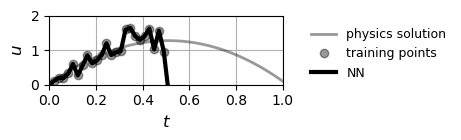

epoch:32000 - train_loss:  0.000000


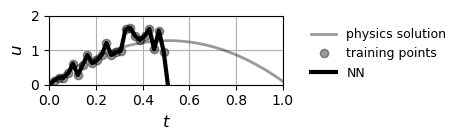

epoch:36000 - train_loss:  0.000005


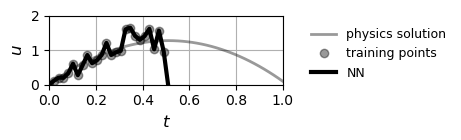

In [7]:
optimizer = torch.optim.Adam(model.parameters(),lr=1e-2)
verbose_training = 4000
verbose_plot = 4000
n_epochs = 40000

NN_l1_hist = sum(abs(p).sum() for p in model.NN.parameters()).detach().numpy()
NN_l2_hist = sum(pow(p,2).sum() for p in model.NN.parameters()).detach().numpy()

# Training up to epochs = n_epochs
for i in range(n_epochs):
    # training procedure
    optimizer.zero_grad()
    u_i_pred = model(t_i) # make prediction
    MSE_u = torch.mean((u_i_pred-u_i)**2) # MSE_u
    MSE_u.backward() # backpropagate loss
    optimizer.step()
    
    # compute and store l1 and l2 norms
    if i % verbose_training == 0:
        l1_reg = sum(abs(p).sum() for p in model.NN.parameters())
        l2_reg = sum(pow(p,2).sum() for p in model.NN.parameters())
        NN_l1_hist = np.hstack((NN_l1_hist,l1_reg.detach().numpy()))
        NN_l2_hist = np.hstack((NN_l2_hist,l2_reg.detach().numpy()))

    # print loss
    if i % verbose_training == 0:
        print('epoch:{:5.0f}'.format(i),'- train_loss:{:10.6f}'.format(MSE_u.item()))
    
    # display predictions every epoch multiple of verbose_plot
    if i% verbose_plot == 0:
        u_pred = model(torch.tensor(t)[:,None]).detach()
        fig = plt.figure(dpi=100, figsize=(5, 1.5), tight_layout=True)
        ax = fig.subplots(1)
        ax.plot(t, u, color="black", linewidth=2, alpha=0.4, label="physics solution")
        ax.plot(t_i, u_i, marker='o', color='black', markersize=6, linewidth=0, alpha=0.4, label='training points')        
        ax.plot(t, u_pred, color='black', linewidth=3,alpha=1, label='NN')        
        l = plt.legend(loc=(1.1,0.), frameon=False, fontsize="9")
        ax.grid()
        ax.set_xlim(0,1)
        ax.set_ylim(0,2)
        ax.set_ylabel('$u$',fontsize="12")
        ax.set_xlabel('$t$',fontsize="12")
        fig.patch.set_facecolor('white')
        plt.show()

**Inference:** We evaluate the mean absolute error of the predictions of the trained model with respect to the ground-truth trajectory points (without synthetic noise) in the interpolation range, $t\in \left[0,0.5\right]$, and the extrapolation range, $t\in \left[0.5,1\right]$.

In [8]:
# Make predictions
u_pred = model(torch.tensor(t)[:,None]).detach().numpy()[:,0]
# Compute mean absolute errors
NN_MAE_i = np.mean(np.abs(u_pred[:n_snapshots//2]-u[:n_snapshots//2]))
NN_MAE_e = np.mean(np.abs(u_pred[n_snapshots//2:]-u[n_snapshots//2:]))
print('MAE interpolation: ', NN_MAE_i)
print('MAE extrapolation: ', NN_MAE_e)

MAE interpolation:  0.17491506
MAE extrapolation:  0.9370855


**Visualize results:** We can see (without any surprise) that the neural network tends to overfit the training data, and the associated noise.

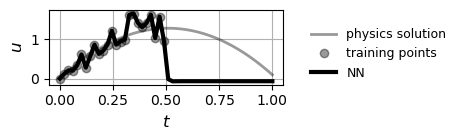

In [9]:
fig = plt.figure(dpi=100, figsize=(5, 1.5), tight_layout=True)
ax = fig.subplots(1)
ax.plot(t, u, color="black", linewidth=2, alpha=0.4, label="physics solution")
ax.plot(t_i, u_i, marker='o', color='black', markersize=6, linewidth=0, alpha=0.4, label='training points')        
ax.plot(t, u_pred, color='black', linewidth=3,alpha=1, label='NN')        
l = plt.legend(loc=(1.1,0.), frameon=False, fontsize="9")
ax.grid()
ax.set_ylabel('$u$',fontsize="12")
ax.set_xlabel('$t$',fontsize="12")
fig.patch.set_facecolor('white')
plt.show()

**[TODO]**
- Note down the Mean Absolute Error for both the interpolation and extrapolation range.
- Do you think that the model is able to "re-discover" ballistics?

### 3. Physics-informed neural network

Let us see what happens if we provide prior knowledge based on physics to the same neural network we trained above.

We train the PINN analog of the same neural network and in order to discover the underlying governing equation, we assume the following physical model:

$
\varrho(t) \equiv \ddot{u}_{\boldsymbol{\theta}} + \gamma,
$

where $\gamma$ is a trainable parameter -- in the code snippet above, `NeuralNet.gamma` -- and $\varrho$ is the residual (for a perfectly trained network, the residual is expected to be zero). Reformulating, we are telling the network that the second order derivative of the solution is equal to an undetermined constant, that the network will eventually identify.

During the learning process, we minimize the combination of two losses, namely:

$
\mathcal{L}_u = \frac{1}{N_u} \sum_{i=1}^{N_u} \left \lVert {u}_{\boldsymbol{\theta}}\left(t^{i}\right) -{u}^{i} \right \rVert
$

$
\mathcal{L}_{\text{PDE}} = \dfrac{1}{N_{\text{PDE}}} \sum_{k=1}^{N_{\text{PDE}}} \left \lVert \varrho \left(t^{k}\right) \right \rVert,
$

where the first term $\mathcal{L}_u$ is equivalent to the loss term of a standard neural network, while the second term $\mathcal{L}_{\text{PDE}}$ represents the residual of the physical model.
For the evaluation of the latter, we sample uniformly distributed time (collocation) points $t^{(k)}\in [0,1]$ s. Automatic differentiation is used to compute $\ddot{u}_{\boldsymbol{\theta}}$ relying on PyTorch's functionality `torch.autograd.grad()`.

But first, we (re-)create the model from scratch, as before:

In [10]:
model = NeuralNet(NN_params,dtype)
model.apply(model.init_weights)

print(model)

NeuralNet(
  (NN): Sequential(
    (0): Linear(in_features=1, out_features=12, bias=True)
    (1): Tanh()
    (2): Linear(in_features=12, out_features=12, bias=True)
    (3): Tanh()
    (4): Linear(in_features=12, out_features=1, bias=True)
  )
)


The training procedure is exactly as before, but this time we add the physical loss (`MSE_PDE`) to the previous one (`MSE_u`).

epoch:    0 - train_loss:  0.730581


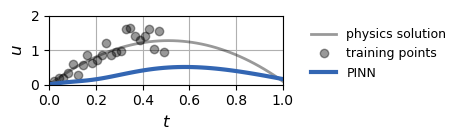

epoch: 4000 - train_loss:  0.054027


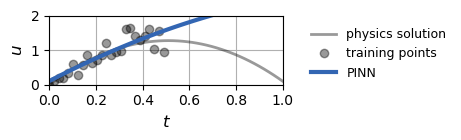

epoch: 8000 - train_loss:  0.051249


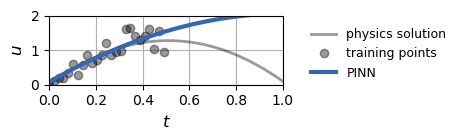

epoch:12000 - train_loss:  0.048907


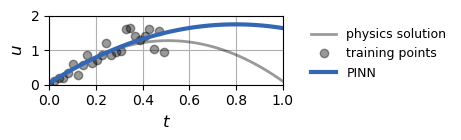

epoch:16000 - train_loss:  0.047066


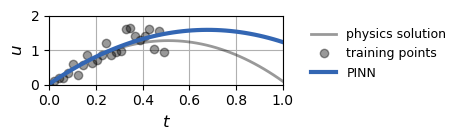

epoch:20000 - train_loss:  0.045744


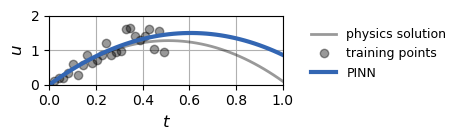

epoch:24000 - train_loss:  0.044973


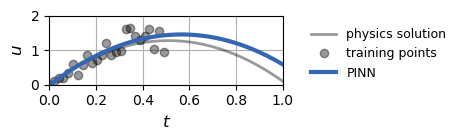

epoch:28000 - train_loss:  0.045281


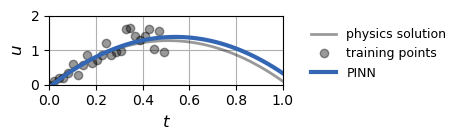

epoch:32000 - train_loss:  0.044362


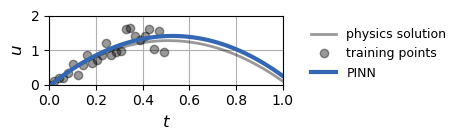

epoch:36000 - train_loss:  0.044208


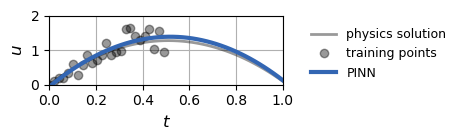

In [11]:
t_k = torch.linspace(0,1,20).view(-1,1).requires_grad_(True) # collocation points
optimizer = torch.optim.Adam(model.parameters(),lr=1e-2)
verbose_training = 4000
verbose_plot = 4000
n_epochs = 40000
lambda_PDE = 0.5

PINN_l1_hist = sum(abs(p).sum() for p in model.NN.parameters()).detach().numpy()
PINN_l2_hist = sum(pow(p,2).sum() for p in model.NN.parameters()).detach().numpy()

# Training
for i in range(n_epochs):
    # training procedure
    optimizer.zero_grad()
    u_i_pred = model(t_i) # make prediction
    MSE_u = torch.mean((u_i_pred-u_i)**2) # MSE_u
    u_k_pred = model(t_k)
    dudt  = torch.autograd.grad(u_k_pred, t_k, torch.ones_like(u_k_pred), create_graph=True)[0] # computes du/dt
    dduddt = torch.autograd.grad(dudt,  t_k, torch.ones_like(dudt), create_graph=True)[0]# computes d^2u/dt^2
    physics = dduddt + model.gamma # computes the residual
    MSE_PDE = lambda_PDE*torch.mean(physics**2) # MSE_PDE
    loss = MSE_u + MSE_PDE # add two loss terms together
    loss.backward() # backpropagate joint loss
    optimizer.step()
    
    # compute and store l1 and l2 norms
    if i % verbose_training == 0:
        l1_reg = sum(abs(p).sum() for p in model.NN.parameters())
        l2_reg = sum(pow(p,2).sum() for p in model.NN.parameters())
        PINN_l1_hist = np.hstack((PINN_l1_hist,l1_reg.detach().numpy()))
        PINN_l2_hist = np.hstack((PINN_l2_hist,l2_reg.detach().numpy()))

    # print loss
    if i % verbose_training == 0:
        print('epoch:{:5.0f}'.format(i),'- train_loss:{:10.6f}'.format(MSE_u.item()))
        
    # display predictions every epoch multiple of verbose_plot
    if i% verbose_plot == 0:
        # Display predictions every epoch multiple of verbose_plot
        u_pred = model(torch.tensor(t)[:,None]).detach()
        fig = plt.figure(dpi=100, figsize=(5, 1.5), tight_layout=True)
        ax = fig.subplots(1)
        ax.plot(t, u, color="black", linewidth=2, alpha=0.4, label="physics solution")
        ax.plot(t_i, u_i, marker='o', color='black', markersize=6,linewidth=0, alpha=0.4, label='training points')        
        ax.plot(t, u_pred, color=colorb, linewidth=3,alpha=1, label='PINN')        
        l = plt.legend(loc=(1.1,0.), frameon=False, fontsize="9")
        ax.grid()
        ax.set_xlim(0,1)
        ax.set_ylim(0,2)
        ax.set_ylabel('$u$',fontsize="12")
        ax.set_xlabel('$t$',fontsize="12")
        fig.patch.set_facecolor('white')
        plt.show()

**Inference:** We evaluate the mean absolute error of the predictions of the trained model with respect to the ground-truth trajectory points (without synthetic noise) in the interpolation range, $t\in \left[0,0.5\right]$, and the extrapolation range, $t\in \left[0.5,1\right]$.

In [12]:
# Make predictions
u_pred = model(torch.tensor(t)[:,None]).detach().numpy()[:,0]
# Compute mean absolute errors
PINN_MAE_i = np.mean(np.abs(u_pred[:n_snapshots//2]-u[:n_snapshots//2]))
PINN_MAE_e = np.mean(np.abs(u_pred[n_snapshots//2:]-u[n_snapshots//2:]))
print('MAE interpolation: ', PINN_MAE_i)
print('MAE extrapolation: ', PINN_MAE_e)

MAE interpolation:  0.066321366
MAE extrapolation:  0.07173374


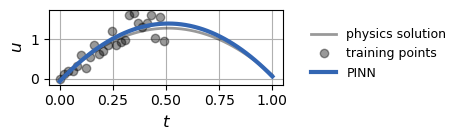

In [13]:
fig = plt.figure(dpi=100, figsize=(5, 1.5), tight_layout=True)
ax = fig.subplots(1)
ax.plot(t, u, color="black", linewidth=2, alpha=0.4, label="physics solution")
ax.plot(t_i, u_i, marker='o', color='black', markersize=6,linewidth=0,alpha=0.4, markeredgecolor='black',label='training points')        
ax.plot(t, u_pred, color=colorb, linewidth=3,alpha=1, label='PINN')        
l = plt.legend(loc=(1.1,0.), frameon=False, fontsize="9")
ax.grid()
ax.set_ylabel('$u$',fontsize="12")
ax.set_xlabel('$t$',fontsize="12")
fig.patch.set_facecolor('white')
plt.show()

**[TODO]** What is the value of $\gamma$ found by PINN? [...]

**[TODO]** Is it in agreement with the physics of the projectile motion? [Y/N]

**[TODO]** Order from the most to the less accurate the following neural network models:
- Standard NN with ReLU activations
- Standard NN with Tanh activations
- PINN with ReLU activations
- PINN with Tanh activations

*Hint:* Go back to the second cell in Section 2 of this notebook and try to change the activation function of the hidden layers (ReLU/Tanh) and repeat the training of both networks [restart the kernel!]

**[TODO-Advanced]** What can you say from the evolution of the $\ell_1$ and $\ell_2$ norms of the parameters of the traditional neural network and its physics-informed sibling?

*Hint*: see the cell below

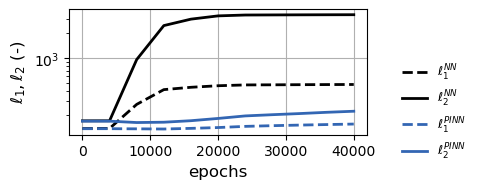

In [14]:
epochs = np.arange(0,n_epochs+1,verbose_training)

fig = plt.figure(dpi=100, figsize=(5, 2), tight_layout=True)
ax = fig.subplots(1)
ax.semilogy(epochs,NN_l1_hist, color='black', linewidth=2,alpha=1,linestyle='--',label='$\ell^{NN}_1$')        
ax.semilogy(epochs,NN_l2_hist, color='black', linewidth=2,alpha=1,label='$\ell^{NN}_2$')        
ax.semilogy(epochs,PINN_l1_hist, color=colorb, linewidth=2,alpha=1,linestyle='--',label='$\ell^{PINN}_1$')  
ax.semilogy(epochs,PINN_l2_hist, color=colorb, linewidth=2,alpha=1,label='$\ell^{PINN}_2$')      
ax.plot(0,0)
l = plt.legend(loc=(1.1,-0.25), frameon=False, fontsize="9")
ax.grid()
ax.set_ylabel('$\ell_1, \ell_2$ (-)',fontsize="12")
ax.set_xlabel('epochs',fontsize="12")
fig.patch.set_facecolor('white')
plt.show()